In [57]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pickle

import scipy
import numpy as np

from astropy.io import fits
from astropy.table import Table, Column, vstack, hstack
from astropy.stats import sigma_clipped_stats, sigma_clip

import matplotlib as mpl
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DECaLS COSMOS Catalogs

- The RA, Dec boundaries are: RA= [149.22484, 150.81303], Dec=[1.541319, 2.87744]

In [48]:
decals_dir = '/Users/song/Downloads/'

tr_1 = Table.read(os.path.join(decals_dir, 'sweep-140p000-150p005.fits'))
tr_2 = Table.read(os.path.join(decals_dir, 'sweep-150p000-160p005.fits'))

pz_1 = Table.read(os.path.join(decals_dir, 'sweep-140p000-150p005-pz.fits'))
pz_2 = Table.read(os.path.join(decals_dir, 'sweep-150p000-160p005-pz.fits'))

print(len(tr_1), len(tr_2))

4142555 4070265


In [63]:
ra_min, ra_max = 149.22484, 150.81303
dec_min, dec_max = 1.541319, 2.87744 

In [54]:
print(tr_1.colnames)

['RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 'DCHISQ', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4', 'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_Z', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'WISEMASK_W1', 'WISEMASK_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH

In [55]:
print(pz_1.colnames)

['RELEASE', 'BRICKID', 'OBJID', 'Z_PHOT_MEAN', 'Z_PHOT_MEDIAN', 'Z_PHOT_STD', 'Z_PHOT_L68', 'Z_PHOT_U68', 'Z_PHOT_L95', 'Z_PHOT_U95', 'Z_SPEC', 'SURVEY', 'TRAINING']


In [56]:
pz_1.rename_column('RELEASE', 'RELEASE_PZ')
pz_1.rename_column('BRICKID', 'BRICKID_PZ')
pz_1.rename_column('OBJID', 'OBJID_PZ')

pz_2.rename_column('RELEASE', 'RELEASE_PZ')
pz_2.rename_column('BRICKID', 'BRICKID_PZ')
pz_2.rename_column('OBJID', 'OBJID_PZ')

In [60]:
decals_comb = vstack([hstack([tr_1, pz_1]), hstack([tr_2, pz_2])])

assert np.all(a['RELEASE'] == a['RELEASE_PZ'])
assert np.all(a['BRICKID'] == a['BRICKID_PZ'])
assert np.all(a['OBJID'] == a['OBJID_PZ'])

In [64]:
cos_mask = (
    (decals_comb['RA'] >= ra_min) & (decals_comb['RA'] <= ra_max) &
    (decals_comb['DEC'] >= dec_min) & (decals_comb['DEC'] <= dec_max)
)

decals_cos = decals_comb[cos_mask]

print(len(decals_cos))

184140


In [65]:
decals_cos.remove_columns(['RELEASE_PZ', 'BRICKID_PZ', 'OBJID_PZ'])

In [66]:
decals_cos.write(os.path.join(decals_dir, 'decals_tractor_photoz_cosmos2020_hsc.fits'))

In [74]:
mask_valid = (
    (decals_cos['NOBS_G'] > 1) & (decals_cos['NOBS_R'] > 1) & (decals_cos['NOBS_Z'] > 1) & 
    (decals_cos['FLUX_IVAR_G'] > 0) & (decals_cos['FLUX_IVAR_R'] > 0) & (decals_cos['FLUX_IVAR_Z'] > 0) &
    (decals_cos['FLUX_G'] > 0) & (decals_cos['FLUX_R'] > 0) & (decals_cos['FLUX_Z'] > 0) &
    (decals_cos['Z_PHOT_MEAN'] >= 0.0) & (decals_cos['Z_PHOT_MEAN'] <= 7.0)
)

print(mask_valid.sum())

mask_good = (
    (decals_cos['NOBS_G'] >= 3) & (decals_cos['NOBS_R'] >= 3) & (decals_cos['NOBS_Z'] >= 3) & 
    (decals_cos['FLUX_IVAR_G'] > 0) & (decals_cos['FLUX_IVAR_R'] > 0) & (decals_cos['FLUX_IVAR_Z'] > 0) &
    (decals_cos['FLUX_G'] > 0) & (decals_cos['FLUX_R'] > 0) & (decals_cos['FLUX_Z'] > 0) &
    (decals_cos['Z_PHOT_MEAN'] >= 0.0) & (decals_cos['Z_PHOT_MEAN'] <= 7.0)
)

print(mask_good.sum())

decals_valid = decals_cos[mask_valid]
decals_good = decals_cos[mask_good]

176523
136152


/tmp/ipykernel_89889/2500048066.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


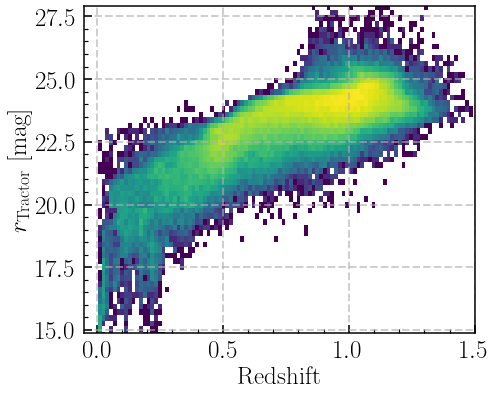

In [90]:
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    decals_good['Z_PHOT_MEAN'], -2.5 * np.log10(decals_good['FLUX_R']) + 22.5, 
    bins=(100, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.05, 1.5)
_ = ax.set_ylim(14.9, 27.9)

_ = ax.set_xlabel(r'$\rm Redshift$', fontsize=25)
_ = ax.set_ylabel(r'$r_{\rm Tractor}\ [\rm mag]$', fontsize=25)

In [84]:
((decals_valid['Z_PHOT_L68'] >= 0.05) & (decals_valid['Z_PHOT_U68'] <= 0.45)).sum()

10823

## COSMOS 2020 Farmer Catalog

- [The COSMOS2020 catalog](https://astroweaver.github.io/project/cosmos2020-galaxy-catalog/)
    - [COSMOS2020: A panchromatic view of the Universe to z∼10 from two complementary catalogs](https://arxiv.org/abs/2110.13923)

In [2]:
cosmos_dir = '/Users/song/work/cosmos2020/COSMOS2020_R1/'

glob.glob(cosmos_dir + '*.fits')

['/Users/song/work/cosmos2020/COSMOS2020_R1/COSMOS2020_FARMER_R1_v2.0.fits',
 '/Users/song/work/cosmos2020/COSMOS2020_R1/COSMOS2020_CLASSIC_R1_v2.0.fits']

- We are going to make use of the `FARMER` catalog based on the `Tractor` code
    - Since that's also the code used for LegacySurvey imaging data analysis.

In [3]:
c20_farmer = Table.read(os.path.join(cosmos_dir, 'COSMOS2020_FARMER_R1_v2.0.fits'))

print(len(c20_farmer))

964506


In [11]:
cols_use = ['ID', 'ID_CLASSIC', 'ALPHA_J2000', 'DELTA_J2000', 'N_GROUP', 'FLAG_HSC', 'FLAG_UVISTA', 'FLAG_COMBINED', 'EBV_MW', 
            'HSC_g_MAG', 'HSC_g_MAGERR', 'HSC_g_CHISQ', 'HSC_g_VALID', 
            'HSC_r_MAG', 'HSC_r_MAGERR', 'HSC_r_CHISQ', 'HSC_r_VALID', 
            'HSC_i_MAG', 'HSC_i_MAGERR', 'HSC_i_CHISQ', 'HSC_i_VALID', 
            'HSC_z_MAG', 'HSC_z_MAGERR', 'HSC_z_CHISQ', 'HSC_z_VALID', 
            'HSC_y_MAG', 'HSC_y_MAGERR', 'HSC_y_CHISQ', 'HSC_y_VALID', 
            'UVISTA_Y_MAG', 'UVISTA_Y_MAGERR', 'UVISTA_Y_CHISQ', 'UVISTA_Y_VALID',
            'UVISTA_J_MAG', 'UVISTA_J_MAGERR', 'UVISTA_J_CHISQ', 'UVISTA_J_VALID',
            'UVISTA_H_MAG', 'UVISTA_H_MAGERR', 'UVISTA_H_CHISQ', 'UVISTA_H_VALID',
            'UVISTA_Ks_MAG', 'UVISTA_Ks_MAGERR', 'UVISTA_Ks_CHISQ', 'UVISTA_Ks_VALID',
            'F814W_MAG', 'F814W_MAGERR', 
            'lp_zBEST', 'lp_type', 'lp_zPDF', 'lp_zPDF_l68', 'lp_zPDF_u68', 
            'lp_MNUV', 'lp_MU', 'lp_MR', 'lp_MZ', 'lp_MJ', 
            'lp_mass_med', 'lp_mass_med_min68', 'lp_mass_med_max68', 'lp_mass_best', 
            'lp_SFR_med', 'lp_SFR_med_min68', 'lp_SFR_med_max68', 'lp_SFR_best', 
            'lp_sSFR_med', 'lp_sSFR_med_min68', 'lp_sSFR_med_max68', 'lp_sSFR_best',
            'ez_z_phot', 'ez_z_phot_chi2', 'ez_z025', 'ez_z160', 'ez_z500', 'ez_z840', 'ez_z975',
            'ez_restU', 'ez_restU_err', 'ez_restB', 'ez_restB_err', 'ez_restV', 'ez_restV_err', 'ez_restJ', 'ez_restJ_err',
            'ez_ssfr_p025', 'ez_ssfr_p160', 'ez_ssfr_p500', 'ez_ssfr_p840', 'ez_ssfr_p975',
            'ez_mass', 'ez_sfr'
           ] 

c20_short = c20_farmer[cols_use]

c20_short.rename_column('ALPHA_J2000', 'ra')
c20_short.rename_column('DELTA_J2000', 'dec')

In [49]:
# The HSC masked region
c20_hsc = c20_short[c20_short['FLAG_HSC'] == 0]

print(len(c20_hsc))

958926


In [51]:
## RA, Dec boundaries

print(c20_hsc['ra'].min(), c20_hsc['ra'].max())
print(c20_hsc['dec'].min(), c20_hsc['dec'].max())

149.22483699123012 150.8130254878658
1.5413190011997577 2.8774402606046996


In [52]:
c20_hsc.write(os.path.join(cosmos_dir, 'cosmos2020_farmer_hsc_short.fits'))

In [82]:
c20_valid = c20_hsc[
    np.isfinite(c20_hsc['lp_zBEST']) & np.isfinite(c20_hsc['lp_mass_med']) & 
    np.isfinite(c20_hsc['lp_SFR_med']) & np.isfinite(c20_hsc['lp_sSFR_med']) &
    np.isfinite(c20_hsc['HSC_g_MAG']) & np.isfinite(c20_hsc['HSC_g_MAGERR']) &
    np.isfinite(c20_hsc['HSC_r_MAG']) & np.isfinite(c20_hsc['HSC_r_MAGERR']) &
    np.isfinite(c20_hsc['HSC_i_MAG']) & np.isfinite(c20_hsc['HSC_i_MAGERR']) &
    np.isfinite(c20_hsc['HSC_z_MAG']) & np.isfinite(c20_hsc['HSC_z_MAGERR']) &
    np.isfinite(c20_hsc['HSC_y_MAG']) & np.isfinite(c20_hsc['HSC_y_MAGERR'])
]

print(len(c20_valid))

674834


In [117]:
c20_lowz_massive = c20_valid[
    (c20_valid['lp_zPDF_l68'] >= 0.05) & (c20_valid['lp_zPDF_l68'] <= 0.45) &
    (c20_valid['lp_mass_med_min68'] >= 10.8) & (c20_valid['lp_mass_med_max68'] <= 12.7)
]

print(len(c20_lowz_massive))

376


/tmp/ipykernel_89889/4209240060.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


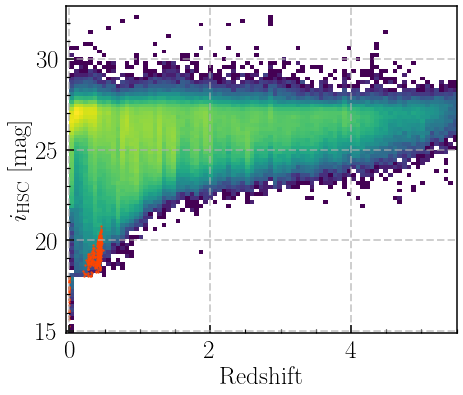

In [131]:
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    c20_valid['lp_zBEST'], c20_valid['HSC_i_MAG'], 
    bins=(150, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

#ax.hist2d(
#    decals_good['Z_PHOT_MEAN'], -2.5 * np.log10(decals_good['FLUX_R']) + 22.5, 
#    bins=(100, 100), cmin=1, cmap='Reds', norm=mpl.colors.LogNorm(), alpha=0.5)

ax.scatter(
    c20_lowz_massive['lp_zBEST'], c20_lowz_massive['HSC_i_MAG'], s=2, c='orangered', alpha=0.8
)

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-0.05, 5.5)
_ = ax.set_ylim(14.9, 32.9)

_ = ax.set_xlabel(r'$\rm Redshift$', fontsize=25)
_ = ax.set_ylabel(r'$i_{\rm HSC}\ [\rm mag]$', fontsize=25)

In [123]:
print(c20_lowz_massive['HSC_g_MAG'].max(), len(c20_lowz_massive) / (c20_valid['HSC_g_MAG'] <= c20_lowz_massive['HSC_g_MAG'].max()).sum())
print(c20_lowz_massive['HSC_r_MAG'].max(), len(c20_lowz_massive) / (c20_valid['HSC_r_MAG'] <= c20_lowz_massive['HSC_r_MAG'].max()).sum())
print(c20_lowz_massive['HSC_i_MAG'].max(), len(c20_lowz_massive) / (c20_valid['HSC_i_MAG'] <= c20_lowz_massive['HSC_i_MAG'].max()).sum())
print(c20_lowz_massive['HSC_z_MAG'].max(), len(c20_lowz_massive) / (c20_valid['HSC_z_MAG'] <= c20_lowz_massive['HSC_z_MAG'].max()).sum())

23.187655772558237 0.02777572578857945
21.582617360579512 0.06458261765716249
20.766340460014433 0.09073359073359073
20.27679095876296 0.11104548139397519


In [132]:
gr_valid = c20_valid['HSC_g_MAG'] - c20_valid['HSC_r_MAG']
rz_valid = c20_valid['HSC_r_MAG'] - c20_valid['HSC_z_MAG']
gz_valid = c20_valid['HSC_g_MAG'] - c20_valid['HSC_z_MAG']

gr_lowz_massive = c20_lowz_massive['HSC_g_MAG'] - c20_lowz_massive['HSC_r_MAG']
rz_lowz_massive = c20_lowz_massive['HSC_r_MAG'] - c20_lowz_massive['HSC_z_MAG']
gz_lowz_massive = c20_lowz_massive['HSC_g_MAG'] - c20_lowz_massive['HSC_z_MAG']

In [181]:
_, gr_low, gr_upp = sigma_clip(gr_lowz_massive, sigma_lower=3, sigma_upper=3, maxiters=5, masked=False, return_bounds=True)
_, gz_low, gz_upp = sigma_clip(gz_lowz_massive, sigma_lower=3, sigma_upper=3, maxiters=5, masked=False, return_bounds=True)
_, rz_low, rz_upp = sigma_clip(rz_lowz_massive, sigma_lower=3, sigma_upper=3, maxiters=5, masked=False, return_bounds=True)

print(gr_low, gr_upp)
print(gz_low, gz_upp)
print(rz_low, rz_upp)

0.9271752545430443 2.0621687835566895
1.6533307511995918 3.3133094011228845
0.6345069834111415 1.3006927594449045


/tmp/ipykernel_89889/489291254.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(


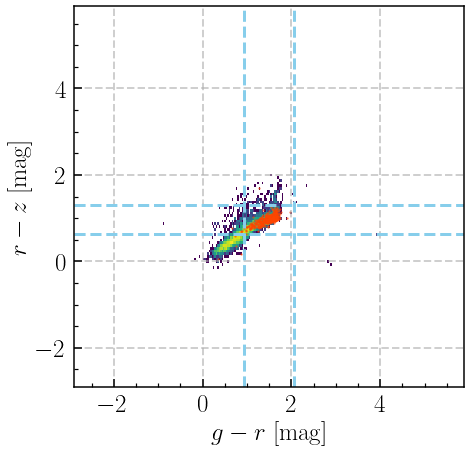

In [182]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

# 2-D histogram
ax.hist2d(
    gr_valid[(c20_valid['HSC_r_MAG'] <= c20_lowz_massive['HSC_r_MAG'].max())], rz_valid[(c20_valid['HSC_r_MAG'] <= c20_lowz_massive['HSC_r_MAG'].max())], 
    bins=(150, 100), cmin=1, cmap='viridis', norm=mpl.colors.LogNorm())

#ax.hist2d(
#    decals_good['Z_PHOT_MEAN'], -2.5 * np.log10(decals_good['FLUX_R']) + 22.5, 
#    bins=(100, 100), cmin=1, cmap='Reds', norm=mpl.colors.LogNorm(), alpha=0.5)

ax.scatter(
    gr_lowz_massive, rz_lowz_massive,
    s=2, c='orangered', alpha=0.5
)

ax.axvline(gr_low, c='skyblue', lw=3, ls='--')
ax.axvline(gr_upp, c='skyblue', lw=3, ls='--')
ax.axhline(rz_low, c='skyblue', lw=3, ls='--')
ax.axhline(rz_upp, c='skyblue', lw=3, ls='--')

ax.grid(linestyle='--', linewidth=2, alpha=0.6)

_ = ax.set_xlim(-2.9, 5.9)
_ = ax.set_ylim(-2.9, 5.9)

_ = ax.set_xlabel(r'$g-r \ [\rm mag]$', fontsize=25)
_ = ax.set_ylabel(r'$r-z \ [\rm mag]$', fontsize=25)

In [180]:
temp = c20_lowz_massive[gz_lowz_massive < gz_low]

_ = [print("{:7d}  {:8.4f}  {:8.4f}".format(obj['ID'], obj['ra'], obj['dec'])) for obj in temp]

 101949  150.4773    2.7976
 155225  150.4647    2.7201
 170745  150.5662    2.4726
 194530  149.6949    2.2207
 291030  149.5094    2.2319
 363766  149.8767    2.4036
 385457  149.7884    2.2271
 394257  150.3476    2.1483
 401128  150.0511    1.9894
 427483  150.4238    2.7393
 427786  149.8599    2.1488
 432763  149.9392    1.7574
 591672  150.2163    1.7418
 621178  150.7702    2.4192
 628319  150.4131    1.7619
 711622  150.1929    1.7524
 801514  150.3834    2.4303
 824201  150.1251    1.6169
 842333  150.4832    1.7782
 861184  149.9080    2.6089
 906028  149.8271    2.1893
 923158  150.1740    1.6119
 950981  150.1295    1.9563


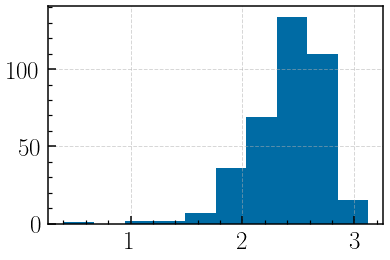

In [173]:
_ = plt.hist(gz_lowz_massive)

## Estimating Object Number and Density in COSMOS

### Number Counts

- Fig 11 in the paper shows the number count statistics in the 1.403/1.234 deg$^2$ region of the HSC-masked UltraVista region for the `CLASSIC` and `FARMER` catalogs.
    - For the i-band selected sample, there are $10^{4.03}$ galaxies per magnitude per square deg at $i<21.75$ AB mag; $10^{3.66}$ galaxies per magnitude per square deg at $i<20.75$ AB mag.
    
#### Compared to DESI:

- BGS Bright $r < 19.5$ mag; ~800 deg$-2$.
- BGS Faint $19.5 < r < 20$ mag; ~600 deg$-2$.
- LRG: for DECaLS, the magnitude cut is $z_{\rm fiber} < 21.5$ mag; ~600 deg$-2$.
- ELG: for DECaLS, the magnitude cut is $20 < g < 23.5$ mag; ~2400 deg$-2$

#### Compared to 4MOST

- Galaxy Clusters: $18.0 < r < 22.0$ mag; 1.7M targets
- AGN: $18.0 < r < 22.8$ mag; 1.0M targets
    - Covers 10000 deg$^2$; 
    - Density: ~90 (200) deg$^{-2}$ for X-ray wide (deep) survey; ~20 deg$^{-2}$ for IR wide survey; ~4 deg$^{-2}$ for high-z QSOs.
- WAVES: $18.0 < r < 22.5$ mag; 1.6M targets
    - In ~1200 deg$^2$ for Wide; and ~70 deg^2 for Deep
    - Wide: $Z < 21.1$ mag and $z_{\rm photo} \leq 0.2$; ~0.9M galaxies; ~750 deg$^{-2}$
    - Deep: $Z < 21.25$ mag and $z_{\rm photo} \leq 0.8$; ~0.75M galaxies; ~11000 deg$^{-2}$
        - Deep fields include GAMA23; ELAIS-S; XMMLSS; ECDFS; E-COSMOS
- Cosmology: $20.0 < r < 23.9$ mag; 8M targets: 
    - 7500 deg$^2$ for BG; LRG; QSO; ~1000 deg $^2$ for ELG
    - BG: $0.15 < z < 0.4$; $16 < J < 18$ mag or $R \sim 20.2$ mag; ~250 deg$^{-2}$; 95% complete
    - LRG: $0.4 < z < 0.7$; $18 < J < 19.5$ mag or $R \sim 21.8$ mag; ~400 deg$^{-2}$; 75% complete
    - ELG: $0.6 < z < 1.1$; $21 < g < 23.2$ mag or $R \sim 23.9$ mag; ~1200 deg$^{-2}$; 80% complete
    - QSO: $0.9 < z < 2.2$; $g < 22.5$ mag or $r \sim 22.2$ mag; ~190 deg$^{-2}$; 65% complete
    - QSO-Ly$\alpha$: $2.2 < z < 3.5$; $r < 22.7$ mag or $r \sim 22.2$ mag; ~50 deg$^{-2}$; 90% complete

#### Compared to WEAVE

- [WEAVE-QSO survey](https://www.cefca.es/doc/general_page/160/talks/WEAVE-QSO_Pieri_short.pdf): ~350K Ly$\alpha$ ($z>2$) QSO over ~6000 deg$^2$
    - **Unclear whether this is still on-going**
    - BAO measurement is better than DESI at $z>2$
    - Target selection based on J-PAS, which will be ~100% complete for $r \sim 23.2$ mag Ly$\alpha$ forrest QSOs.
    - Also work with HETDEX
    - Get all Ly$\alpha$ forrest QSOs at $r < 21$ mag.
- [WEAVE-LOFAR survey](https://arxiv.org/pdf/1611.02706.pdf)
    - Spectra of $\sim 10^6$ low-frequency selected radio sources
- WEAVE-Apertif survey:
    - LIFU follow-up of HI detected systems
- WEAVE nearby galaxy cluster survey by J.Alfonso & L.Aguerri (IAC)
    - **Note sure if there is any progress**.
    
#### Compared to PFS

- Based on Takada et al. (2014), very preliminary.

- ELGs for cosmology: $0.6 < z < 2.4$, $22.8 < g < 24.2$ AB mag; >2900 deg$^{-2}$
- Galaxy Evolution Survey: 16 deg$^2$ of HSC Deep, reaching $J = 23.4$ AB mag.
    - $J < 21$ mag for $z<1$: ~6000 deg$^{-2}$
    - $21 < J < 22$ mag for $1 < z< 2$: ~1500 deg$^{-2}$
    - $22 < J < 23$ mag for $1 < z< 2$: ~8400 deg$^{-2}$
    - $23 < J < 23.4$ mag for $1 < z< 2$: ~12000 deg$^{-2}$
    - $J < 23.4$ mag for $z<2$: ~47000 deg$^{-2}$ but only for 2.6 deg$^2$ Ultra-Deep field
    - $i = 24$ LBGs at $2 < z < 3$: ~4600 deg$^{-2}$.
    - $i = 25$ LBGs at $3 < z < 4$: ~840 deg$^{-2}$.
    - $i = 26$ LBGs at $4 < z < 6$: ~100 deg$^{-2}$.
    
#### Compared to MOONS

- [MOONRISE: GTO Extragalactic Survey](https://arxiv.org/pdf/2009.00644.pdf)
    - 1 deg$^2$ in COSMOS; 3-6 deg$^2$ in two other fields.
    - Two observing modes: Xswitch and Stare:
        - Xswitch: 400 pairs of fibers on targets or sky in nodding mode; 207800 objects in 4 deg$^2$.
        - Stare: 900 pairs of fibers on targets; 461700 objects in 7 deg$^2$.
    - $0.9 < z < 1.1$: $H <23.0$ AB mag for $\log M_{\star} > 9.5$ galaxies 
    - $1.2 < z < 1.7$: $H <23.5$ AB mag for $\log M_{\star} > 9.5$ galaxies 
    - $2.0 < z < 2.6$: $H <24.0$ AB mag for $\log M_{\star} > 10.0$ galaxies
    - $z > 5$: $H < 26$ AB mag; about 2000 galaxies

In [28]:
# Only use the objects in the HSC-masked Ultra-Vista region

c20_use = c20_short[c20_short['FLAG_COMBINED'] == 0]

print(len(c20_use))

746976


/tmp/ipykernel_89889/2206918441.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.hist2d(c20_use['ra'], c20_use['dec'], bins=(100, 100))


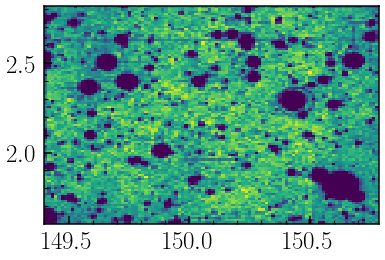

In [31]:
_ = plt.hist2d(c20_use['ra'], c20_use['dec'], bins=(100, 100))

In [32]:
c20_use.write(os.path.join(cosmos_dir, 'cosmos2020_farmer_combined_short.fits'))

In [39]:
lp_flag = (
    np.isfinite(c20_use['lp_zBEST']) & np.isfinite(c20_use['lp_mass_med']) & 
    np.isfinite(c20_use['lp_SFR_med']) & np.isfinite(c20_use['lp_sSFR_med'])
)

hsc_flag = (
    np.isfinite(c20_use['HSC_g_MAG']) & np.isfinite(c20_use['HSC_g_MAGERR']) &
    np.isfinite(c20_use['HSC_r_MAG']) & np.isfinite(c20_use['HSC_r_MAGERR']) &
    np.isfinite(c20_use['HSC_i_MAG']) & np.isfinite(c20_use['HSC_i_MAGERR']) &
    np.isfinite(c20_use['HSC_z_MAG']) & np.isfinite(c20_use['HSC_z_MAGERR']) &
    np.isfinite(c20_use['HSC_y_MAG']) & np.isfinite(c20_use['HSC_y_MAGERR'])
)

print(lp_flag.sum(), hsc_flag.sum())

712476 685165


/tmp/ipykernel_89889/3616463529.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.hist2d(c20_use[lp_flag & hsc_flag]['lp_zBEST'], c20_use[lp_flag & hsc_flag]['HSC_r_MAG'], bins=(300, 100))


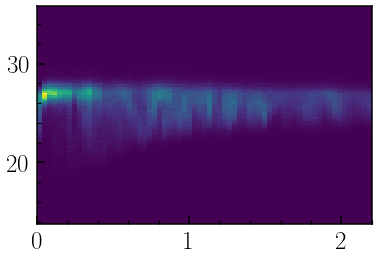

In [42]:
_ = plt.hist2d(c20_use[lp_flag & hsc_flag]['lp_zBEST'], c20_use[lp_flag & hsc_flag]['HSC_r_MAG'], bins=(300, 100))

_ = plt.xlim(0.0, 2.2)

In [45]:
np.linspace(20.0, 24.5, 10)

array([20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5])

In [47]:
np.histogram(c20_use[lp_flag & hsc_flag]['HSC_i_MAG'], bins=np.linspace(20.0, 24.5, 10))

(array([ 1365,  2231,  3782,  5830,  9103, 13378, 19554, 28360, 40170]),
 array([20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5]))